# Importation des packages

In [69]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from xgboost import XGBRegressor
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.pipeline import Pipeline
from joblib import dump



# Importation des données

In [70]:
# Vérifier le répertoire courant
current_directory = os.getcwd()


# Chemin relatif vers le fichier dans le sous-dossier
#file_path1 = os.path.join(current_directory,'..', 'Data', 'X_train_test_pro.csv')
#file_y_test = os.path.join(current_directory,'..', 'Data', 'y_test_pro.csv')
#file_x_test = os.path.join(current_directory,'..', 'Data', 'X_test_pro.csv')

# Charger le fichier CSV
#df = pd.read_csv(file_path1, sep=';')
#X_test = pd.read_csv(file_x_test)
#y_test= pd.read_csv(file_y_test)

# Afficher les premières lignes des fichier
#print(df.head())

## Séparation X_train et Y_train

In [71]:
#X_train=df.drop(columns=['SalePrice'])
#y_train=df['SalePrice']

# Les modèles potentiels

Le choix fait ici est de  tester plusieurs modèles de régression, dont la régression linéaire, ridge, lasso, elasticNet, ainsi que des modèles d'arbres de décision comme RandomForest, XGBoost et AdaBoost, afin de sélectionner le modèle le plus performant pour la prédiction des prix de maisons. Ces choix sont guidés par les raisons ci-après:  

1. Régression linéaire : Ce modèle simple nous sert de référence initiale pour la prédiction des prix de maison. Bien qu'il ne puisse pas capturer les relations non linéaires, il offre une base pour évaluer la performance des modèles plus complexes.  

2. Ridge et Lasso : Ces deux variantes de la régression linéaire régularisée sont adaptées pour gérer des modèles avec un grand nombre de variables, comme c'est le cas ici, et prévenir le sur-apprentissage, ce qui est crucial avec notre nombre relativement limité de données (1460 observations au total).

3. ElasticNet : Ce modèle combine les avantages de la régularisation Lasso et Ridge, ce qui permet de traiter des jeux de données avec des relations complexes tout en sélectionnant les variables les plus pertinentes pour la prédiction.

4. RandomForest : Ce modèle basé sur des arbres de décision, nous permet de capturer des relations non linéaires et des interactions complexes entre les variables, ce qui est particulièrement pertinent dans notre cas. Il est couramment utilisé dans la littérature et les compétitions comme Kaggle pour des problèmes similaires.

5. XGBoost : XGBoost est une méthode de gradient boosting très performante, souvent utilisée dans des compétitions comme Kaggle, en raison de sa capacité à gérer des relations non linéaires et de sa robustesse face aux données bruyantes. Il est bien adapté pour des prédictions complexes comme celles des prix de maison.

6. AdaBoost : Ce modèle, qui combine plusieurs classificateurs faibles pour améliorer la précision, est efficace pour modéliser des données complexes. Bien qu'il soit moins populaire que XGBoost ou RandomForest, il peut offrir de bonnes performances pour prédire les prix de maison en exploitant les interactions subtiles entre les variables.

 Ces modèles variés nous permettrons donc  de comparer des approches simples, régularisées et complexes, et d'identifier celui qui optimise le mieux la performance sur notre jeu de données.

## Fonction de génération des modèles

In [72]:
def train_and_evaluate_single_model(X_train,y_train,X_test, y_test, model_type, params=None):
   
    # Sélectionner et instancier le modèle
    if model_type == "linear":
        model = LinearRegression()
    elif model_type == "ridge":
        alpha = params.get("alpha", 1.0) if params else 1.0
        model = Ridge(alpha=alpha)
    elif model_type == "lasso":
        alpha = params.get("alpha", 1.0) if params else 1.0
        model = Lasso(alpha=alpha)
    elif model_type == "elasticnet":
        alpha = params.get("alpha", 1.0) if params else 1.0
        l1_ratio = params.get("l1_ratio", 0.5) if params else 0.5
        model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
    elif model_type == "RandomForest":
        n_estimators = params.get("n_estimators", 100) if params else 100
        random_state = params.get("random_state", 42) if params else 42
        model= RandomForestRegressor(n_estimators=n_estimators, random_state=random_state)
    elif model_type == "XGBoost":
        n_estimators = params.get("n_estimators", 100) if params else 100
        random_state = params.get("random_state", 42) if params else 42
        learning_rate=params.get("learning_rate", 0.1) if params else 0.1
        objective= params.get("objective", "reg:squarederror") if params else "reg:squarederror"
        model= XGBRegressor(n_estimators=n_estimators, random_state=random_state, learning_rate=learning_rate, objective=objective)
    elif model_type == "AdaBoost":
        n_estimators = params.get("n_estimators", 100) if params else 100
        random_state = params.get("random_state", 42) if params else 42
        model= AdaBoostRegressor(n_estimators=n_estimators, random_state=random_state)
    else:
        raise ValueError("Modèle non supporté. Choisissez parmi 'linear', 'ridge', 'lasso', 'elasticnet'.")

    # Entraîner le modèle
    model.fit(X_train, y_train)

    # Prédictions sur le jeu de test
    y_pred = model.predict(X_test)

    # Calculer les métriques de performance
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)


    return {"mse": mse, "r2": r2}


## Entrainement et test des modèles

In [73]:
# Génération des données aléatoires
np.random.seed(42)  # Pour rendre les résultats reproductibles
X = np.random.rand(100, 5)  # 100 exemples, 5 caractéristiques
y = np.random.rand(100)  # 100 cibles

# Division en données d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Transformation de X_train et X_test en DataFrame pandas avec des noms de colonnes
X_train = pd.DataFrame(X_train, columns=[f"Feature{i+1}" for i in range(X_train.shape[1])])
X_test = pd.DataFrame(X_test, columns=[f"Feature{i+1}" for i in range(X_test.shape[1])])

# Transformation de y_train et y_test en DataFrame pandas avec une colonne "Target"
y_train= pd.DataFrame(y_train, columns=["Target"])
y_test = pd.DataFrame(y_test, columns=["Target"])


# Régression linéaire
metrics_linear = train_and_evaluate_single_model(X_train,y_train,X_test, y_test, model_type="linear")


# Régression Ridge
metrics_ridge = train_and_evaluate_single_model(X_train,y_train,X_test, y_test, model_type="ridge", params={"alpha": 10})

# Régression Lasso
metrics_lasso = train_and_evaluate_single_model(X_train,y_train,X_test, y_test, model_type="lasso", params={"alpha": 0.5})

# Régression Elastic Net
metrics_elasticnet = train_and_evaluate_single_model(X_train,y_train,X_test, y_test, model_type="elasticnet", params={"alpha": 0.5, "l1_ratio": 0.8})

# Régression RandomForest
metrics_RandomForest = train_and_evaluate_single_model(X_train,y_train,X_test, y_test, model_type="RandomForest", params={"n_estimators":100, "random_state":42})

# Régression XGBoost
metrics_XGBoost = train_and_evaluate_single_model(X_train,y_train,X_test, y_test, model_type="XGBoost", params={"n_estimators":100, "learning_rate":0.1, "random_state":42, "objective":"reg:squarederror"})

# Régression AdaBoost
metrics_AdaBoost = train_and_evaluate_single_model(X_train,y_train,X_test, y_test, model_type="AdaBoost", params={"n_estimators":100, "random_state":42})




metrics_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Ridge', 'Lasso', 'Elastic Net','RandomForest','XGBoost','AdaBoost'],
    'R2 Score': [metrics_linear['r2'], metrics_ridge['r2'], metrics_lasso['r2'], metrics_elasticnet['r2'],metrics_RandomForest['r2'],metrics_XGBoost['r2'], metrics_AdaBoost['r2']],
    'MSE': [metrics_linear['mse'], metrics_ridge['mse'], metrics_lasso['mse'], metrics_elasticnet['mse'],metrics_RandomForest['mse'],metrics_XGBoost['mse'], metrics_AdaBoost['mse']]
})

# Afficher les résultats
print(metrics_df)

# Identifier le meilleur modèle en fonction de la métrique R2 (ou autre métrique de votre choix)
best_model = metrics_df.loc[metrics_df['R2 Score'].idxmax()]
best_model_MSE = metrics_df.loc[metrics_df['MSE'].idxmax()]


print(f"\nLe meilleur modèle est : {best_model['Model']} avec un R2 Score de {best_model['R2 Score']}")
print(f"\nLe meilleur modèle est : {best_model_MSE['Model']} avec un R2 Score de {best_model_MSE['MSE']}")

c:\Users\I7 7eme\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


               Model  R2 Score       MSE
0  Linear Regression -0.620759  0.123928
1              Ridge -0.257026  0.096116
2              Lasso -0.122914  0.085862
3        Elastic Net -0.122914  0.085862
4       RandomForest -0.953092  0.149340
5            XGBoost -0.553856  0.118813
6           AdaBoost -0.739654  0.133020

Le meilleur modèle est : Lasso avec un R2 Score de -0.12291359364868137

Le meilleur modèle est : RandomForest avec un R2 Score de 0.14933968680875848


c:\Users\I7 7eme\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Optimisation des hyperparamètres et validation croisée

Cette partie est consacrée à une évaluation optimale de la performance du modèle de régression linéaire et à l'optimisation des hyperparamètres pour pour les autres modèles(Ridge, Lasso, ElasticNet). Ceci va nous permettre d'évaluer un potentiel surajustement de  chaque modèle.

In [74]:
def cross_validate_and_optimize(X_train, y_train, X_test, y_test, model_type="linear", params=None, cv=5):
    """
    Effectue une validation croisée et une optimisation des hyperparamètres pour différents modèles.
    
    - X_train : Les features d'entraînement
    - y_train : La cible d'entraînement
    - X_test : Les features de test
    - y_test : La cible de test
    - model_type : Le type de modèle ("linear", "ridge", "lasso", "elasticnet")
    - params : Dictionnaire des hyperparamètres à tester pour l'optimisation
    - cv : Nombre de folds pour la validation croisée
    """
    # Cas pour régression linéaire : pas d'optimisation d'hyperparamètres
    if model_type == "linear":
        model = LinearRegression()

        # Validation croisée sur les données d'entraînement
        cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
        mean_mse = -cv_scores.mean()  # Les scores sont négatifs, donc on les inverse
        model.fit(X_train, y_train)  # Entraînement du modèle sur les données d'entraînement
        y_pred = model.predict(X_test)  # Prédictions sur les données de test
        test_mse = mean_squared_error(y_test, y_pred)  # MSE sur les données de test
        test_r2 = r2_score(y_test, y_pred)
        
        return {
            "model":model,
            "best_model": model,  # Même modèle ici car il n'y a pas d'optimisation
            "best_params": "N/A",  # Pas de paramètres à optimiser pour la régression linéaire
            "best_mse_train": mean_mse,
            "test_mse": test_mse,
            "test_r2": test_r2
        }

    # Cas pour Ridge, Lasso, et ElasticNet : optimisation des hyperparamètres avec GridSearchCV
    elif model_type in ["ridge", "lasso", "elasticnet", "RandomForest","XGBoost","AdaBoost"]:
        if model_type == "ridge":
            model = Ridge()
            param_grid = {"alpha": np.logspace(-5, 5, 11)}  # Grille pour alpha
        elif model_type == "lasso":
            model = Lasso()
            param_grid = {"alpha": np.logspace(-5, 5, 11)}  # Grille pour alpha
        elif model_type == "elasticnet":
            model = ElasticNet()
            param_grid = {"alpha": np.logspace(-5, 5, 11), "l1_ratio": np.linspace(0, 1, 11)}  # Grille pour alpha et l1_ratio
        elif model_type == "RandomForest":
            model = RandomForestRegressor()
            param_grid = {"n_estimators": [50, 100, 200], "max_depth": [None, 10, 20], "min_samples_split": [2, 5, 10]}
        elif model_type == "XGBoost":
            model = XGBRegressor()
            param_grid =  {"n_estimators": [50, 100, 200],"learning_rate": [0.01, 0.1, 0.2],"max_depth": [3, 5, 7]}
        elif model_type == "AdaBoost":
            model = AdaBoostRegressor()
            param_grid =  {"n_estimators": [50, 100, 200],"learning_rate": [0.01, 0.1, 1]}

        # Si des paramètres sont fournis, on les inclut dans la recherche
        if params:
            param_grid.update(params)

        # GridSearchCV pour optimiser les hyperparamètres
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        
        # Récupérer les résultats du meilleur modèle
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        best_mse_train = -grid_search.best_score_  # Inverser le signe du MSE

        # Entraînement du meilleur modèle sur les données d'entraînement
        best_model.fit(X_train, y_train)

        # Prédictions sur les données de test
        y_pred = best_model.predict(X_test)

        # MSE sur les données de test et de train
        test_mse = mean_squared_error(y_test, y_pred)
        test_r2=r2_score(y_test,y_pred)

        return {
            "model": model,
            "best_model": best_model,
            "best_params": best_params,
            "best_mse_train": best_mse_train,
            "test_mse": test_mse,
             "test_r2": test_r2
        }
    
    else:
        raise ValueError(f"Model type {model_type} not recognized. Choose from 'linear', 'ridge', 'lasso', or 'elasticnet'.")


## Entrainement et test des modèles après optimisation

In [75]:
# Liste pour stocker les résultats
results = []

# Conversion avec squeeze()
y_train = y_train.squeeze()
y_test = y_test.squeeze()

# Appels des fonctions pour chaque modèle
result_linear = cross_validate_and_optimize(X_train, y_train, X_test, y_test, model_type="linear")
results.append([
    result_linear["model"],
    result_linear["best_model"],
    result_linear["best_params"],  # Pas de paramètres pour la régression linéaire
    result_linear["best_mse_train"],         # Moyenne du MSE en train pour la régression linéaire
    result_linear["test_mse"],
    result_linear["test_r2"] 
])

result_ridge = cross_validate_and_optimize(X_train, y_train, X_test, y_test, model_type="ridge", params={"alpha": [10]})
results.append([
    result_ridge["model"],
    result_ridge["best_model"],
    result_ridge["best_params"],
    result_ridge["best_mse_train"],
    result_ridge["test_mse"], 
    result_ridge["test_r2"]  
])

result_lasso = cross_validate_and_optimize(X_train, y_train, X_test, y_test, model_type="lasso", params={"alpha": [0.5]})
results.append([
    result_lasso["model"],
    result_lasso["best_model"],
    result_lasso["best_params"],
    result_lasso["best_mse_train"],
    result_lasso["test_mse"],
    result_lasso["test_r2"]
])

result_elasticnet = cross_validate_and_optimize(X_train, y_train, X_test, y_test, model_type="elasticnet", params={"alpha": [0.5], "l1_ratio": [0.8]})
results.append([
    result_elasticnet["model"],
    result_elasticnet["best_model"],
    result_elasticnet["best_params"],
    result_elasticnet["best_mse_train"],
    result_elasticnet["test_mse"],
    result_elasticnet["test_r2"]
])

result_RandomForest = cross_validate_and_optimize(X_train, y_train, X_test, y_test, model_type="RandomForest", 
                                                  params={"n_estimators": [50, 100, 200], "max_depth": [None, 10, 20], "min_samples_split": [2, 5, 10]})
results.append([
    result_RandomForest["model"],
    result_RandomForest["best_model"],
    result_RandomForest["best_params"],
    result_RandomForest["best_mse_train"],
    result_RandomForest["test_mse"],
    result_RandomForest["test_r2"]
])

result_XGBoost = cross_validate_and_optimize(X_train, y_train, X_test, y_test, model_type="XGBoost", 
                                                  params={"n_estimators": [50, 100, 200],"learning_rate": [0.01, 0.1, 0.2],"max_depth": [3, 5, 7]})
results.append([
    result_XGBoost["model"],
    result_XGBoost["best_model"],
    result_XGBoost["best_params"],
    result_XGBoost["best_mse_train"],
    result_XGBoost["test_mse"],
    result_XGBoost["test_r2"]
])

result_AdaBoost = cross_validate_and_optimize(X_train, y_train, X_test, y_test, model_type="AdaBoost", 
                                                  params={"n_estimators": [50, 100, 200],"learning_rate": [0.01, 0.1, 1]})
results.append([
    result_AdaBoost["model"],
    result_AdaBoost["best_model"],
    result_AdaBoost["best_params"],
    result_AdaBoost["best_mse_train"],
    result_AdaBoost["test_mse"],
    result_AdaBoost["test_r2"]
])

# Convertir les résultats en DataFrame
df_results = pd.DataFrame(results, columns=["Model", "Best Model", "Best Parameters", "Best MSE Train", "Test MSE","test_r2"])

# Afficher les résultats
print(df_results)

# Trouver le meilleur modèle basé sur le MSE de test
top_2_models = df_results.nsmallest(2, "Test MSE")
best_model_row = top_2_models.iloc[0]
best_model_row2 = top_2_models.iloc[1]

print(f"\n Meilleur modèle basé sur le MSE de test: {best_model_row['Model']} avec un MSE de {best_model_row['Test MSE']}")
print(f"\n Second Meilleur modèle basé sur le MSE de test: {best_model_row2['Model']} avec un MSE de {best_model_row['Test MSE']}")



                                               Model  \
0                                 LinearRegression()   
1                                            Ridge()   
2                                            Lasso()   
3                                       ElasticNet()   
4                            RandomForestRegressor()   
5  XGBRegressor(base_score=None, booster=None, ca...   
6                                AdaBoostRegressor()   

                                          Best Model  \
0                                 LinearRegression()   
1                                    Ridge(alpha=10)   
2                                   Lasso(alpha=0.5)   
3                ElasticNet(alpha=0.5, l1_ratio=0.8)   
4  (DecisionTreeRegressor(max_features=1.0, min_s...   
5  XGBRegressor(base_score=None, booster=None, ca...   
6  (DecisionTreeRegressor(max_depth=3, random_sta...   

                                     Best Parameters  Best MSE Train  \
0                             

## Vérification de l'overfitting/underfitting

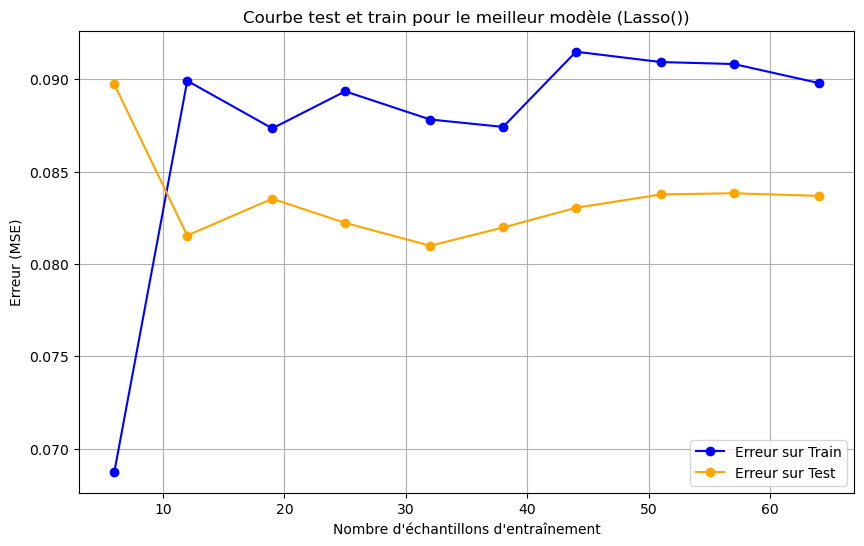

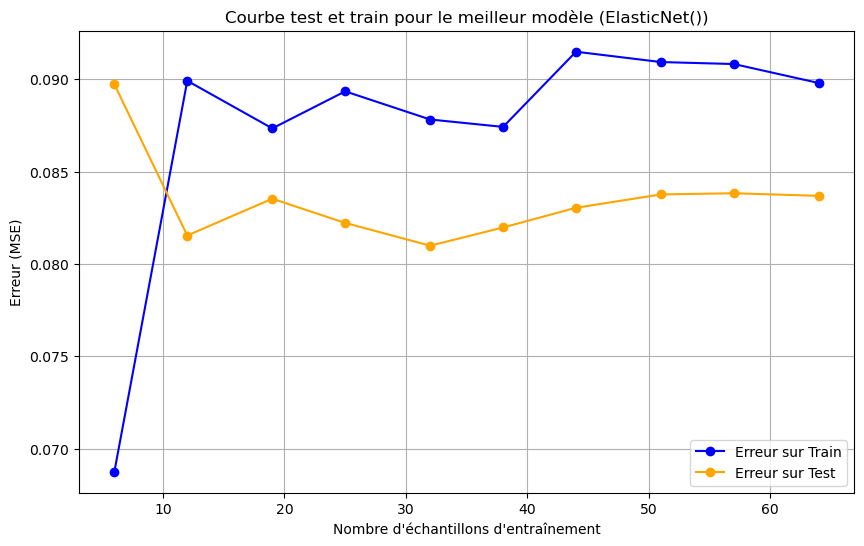

In [76]:
# Tracer les courbes d'apprentissage pour le modèle sélectionné
def plot_learning_curves(model, X, y, scoring='neg_mean_squared_error',title="Courbe d'apprentissage Test et Train"):
    
    # Définir une validation croisée
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

    # Calcul des courbes d'apprentissage
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=cv, scoring=scoring, train_sizes=np.linspace(0.1, 1.0, 10)
    )

    # Moyenne des erreurs (on prend l'opposé car sklearn retourne des scores négatifs pour MSE)
    train_scores_mean = -train_scores.mean(axis=1)
    test_scores_mean = -test_scores.mean(axis=1)

    # Tracer les courbes
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color="blue", label="Erreur sur Train")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="orange", label="Erreur sur Test")

    plt.title(title)
    plt.xlabel("Nombre d'échantillons d'entraînement")
    plt.ylabel("Erreur (MSE)")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

# Appliquer à votre modèle
plot_learning_curves(best_model_row["Best Model"], X_train, y_train, scoring='neg_mean_squared_error',title=f"Courbe test et train pour le meilleur modèle ({best_model_row['Model']})")
plot_learning_curves(best_model_row2["Best Model"], X_train, y_train, scoring='neg_mean_squared_error',title=f"Courbe test et train pour le meilleur modèle ({best_model_row2['Model']})")


## Résultats finaux avec le meilleur modèle


Coefficients et significativités :
    Feature Coefficient P-Value
0  Feature1         N/A     N/A
1  Feature2         N/A     N/A
2  Feature3         N/A     N/A
3  Feature4         N/A     N/A
4  Feature5         N/A     N/A


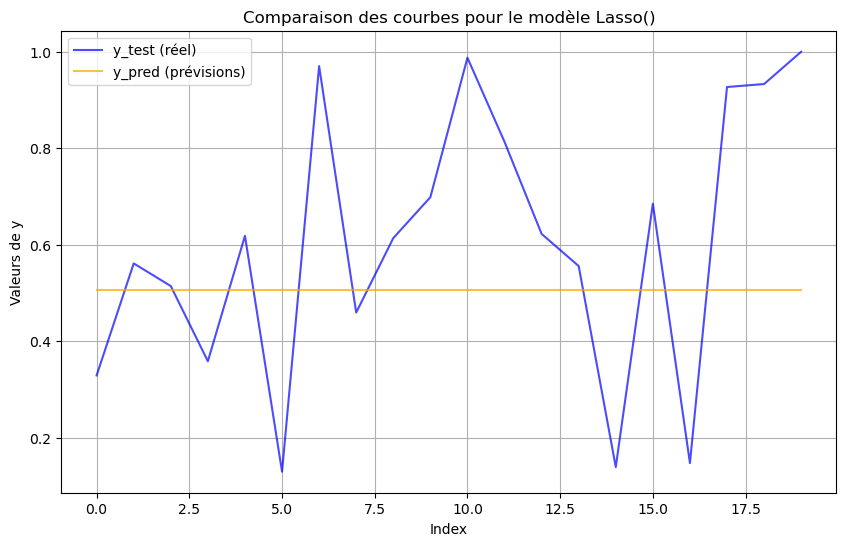


Le MSE final sur le jeu de test est : 0.08586156548817339


In [77]:
# Utilisation du meilleur modèle pour obtenir les coefficients et leur significativité
if best_model_row["Model"] == "LinearRegression()":
    best_model = LinearRegression()
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)

    # Calcul des coefficients et de leur significativité avec statsmodels
    X_train_sm = sm.add_constant(X_train)  # Ajout d'une constante pour le biais
    ols_model = sm.OLS(y_train, X_train_sm).fit()
    coefficients = pd.DataFrame({
        "Feature": ["Intercept"] + list(X_train.columns),
        "Coefficient": ols_model.params,
        "P-Value": ols_model.pvalues
    })

elif best_model_row["Model"] in ["Ridge()", "Lasso()", "ElasticNet()"]:
    best_model = best_model_row["Model"]
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)

    # Extraction des coefficients
    coefficients = pd.DataFrame({
        "Feature": list(X_train.columns),
        "Coefficient": best_model.coef_
    })
    coefficients["P-Value"] = "N/A"  # Les modèles régularisés n'ont pas de significativité statistique

else:
    best_model = best_model_row["Model"]
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)

    # Ces modèles (XGBoost, RandomForest et Adaboost) n'ont pas de coefficients interprétables
    coefficients = pd.DataFrame({
        "Feature": list(X_train.columns),
        "Coefficient": "N/A",
        "P-Value": "N/A"
    })

# Affichage des coefficients et de leurs significativités
print("\nCoefficients et significativités :")
print(coefficients)

# Création d'un graphique comparant y_test et y_pred
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test, label="y_test (réel)", color="blue", alpha=0.7)
plt.plot(range(len(y_pred)), y_pred, label="y_pred (prévisions)", color="orange", alpha=0.7)
plt.title(f"Comparaison des courbes pour le modèle {best_model_row['Model']}")
plt.xlabel("Index")
plt.ylabel("Valeurs de y")
plt.legend()
plt.grid(True)
plt.show()

# Calcul des performances finales
final_mse = mean_squared_error(y_test, y_pred)
print(f"\nLe MSE final sur le jeu de test est : {final_mse}")


## Sauvegarde du modèle 

In [ ]:
# Supposons que le pipeline s'appelle 'pipeline'

# dump(pipeline, 'pipeline_house_prices.joblib')
